# Using Logistic Regression to classify the EMNIST Dataset

EMNIST Dataset is a built-in dataset in PyTorch. EMNIST(letters) dataset is used in this notebook, which contains 26 balanced classes, each representing a letter from the English Alphabet.

#### Importing libraries and the EMNIST dataset 

In [2]:
import torch
import torchvision
from torchvision.datasets import EMNIST

#### Downloading the EMNIST dataset to the notebook

In [3]:
dataset = EMNIST(root='data/', split='letters', download=True)

Extracting data/EMNIST/raw/emnist.zip to data/EMNIST/raw
Processing byclass


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Processing bymerge
Processing balanced
Processing letters
Processing digits
Processing mnist
Done!


#### Exploring the Dataset

In [4]:
len(dataset)

124800

In [5]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7F2C967BAFD0>, 23)

In [6]:
dataset[1]

(<PIL.Image.Image image mode=L size=28x28 at 0x7F2C967BAC18>, 7)

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

15


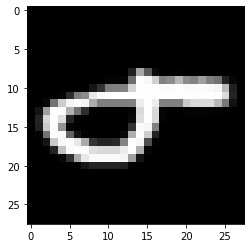

In [8]:
image, label = dataset[2]
label -= 1
plt.imshow(image, cmap='gray')
print(label)

14


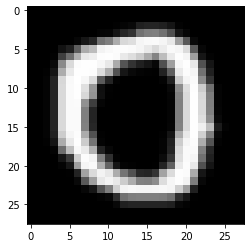

In [9]:
image, label = dataset[3]
label -= 1
plt.imshow(image, cmap='gray')
print(label)

In [10]:
classes = dataset.classes
classes

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

#### Transforming the images in the dataset to tensors 

In [12]:
import torchvision.transforms as transforms

In [13]:
dataset = EMNIST(root='data/', train=True, transform=transforms.ToTensor(), split='letters')
len(dataset)

124800

#### Exploring the image tensors

In [14]:
img_tensor, labels = dataset[0]
print(img_tensor.shape, labels-1)

torch.Size([1, 28, 28]) 22


In [15]:
img_tensor, labels = dataset[1]
print(img_tensor.shape, labels-1)

torch.Size([1, 28, 28]) 6


In [16]:
img_tensor, labels = dataset[2]
print(img_tensor, labels-1)

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

#### Create validation set from the training set

In [17]:
from torch.utils.data import random_split

val_per = 0.1
val_len = int(val_per*len(dataset))
train_ds, val_ds = random_split(dataset, [len(dataset)-val_len, val_len])
print(len(train_ds), len(val_ds))

112320 12480


#### Load the training and validation data in batches

In [18]:
from torch.utils.data import DataLoader

batch_size = 128

train_load = DataLoader(train_ds, batch_size, shuffle=True)
val_load = DataLoader(val_ds, batch_size)

#### Creating a logistic regression model

In [19]:
from torch import nn

input_size = 28*28
output_size = 26

In [20]:
class EmnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, xb):
        xb = xb.reshape(-1, input_size)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, label = batch
        labels = torch.tensor([x-1 for x in label])
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, label = batch
        labels = torch.tensor([x-1 for x in label])
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [21]:
model = EmnistModel()

#### Predictions with the initial hyperparameters

In [22]:
import torch.nn.functional as F

for images, label in train_load:
    labels = torch.tensor([x-1 for x in label])
    outputs = model(images)
    break

In [23]:
probs = F.softmax(outputs, dim=1)

In [24]:
max_probs, preds = torch.max(probs, dim=1)
preds

tensor([21, 21, 21, 25, 25,  9, 16,  0, 25, 21,  0, 21, 25, 24, 21,  0, 25, 25,
        21, 25, 21, 25,  0,  9, 21, 23,  9, 25, 25, 25, 21, 21, 21, 21, 21,  9,
         1,  5,  9,  1, 21, 12, 21, 12, 25, 25, 21, 23, 21,  8, 25, 21, 21, 11,
        25,  9, 21, 21,  9, 25, 21, 21, 14, 21, 21,  9, 21,  1, 25,  9,  1, 25,
         8,  1, 21,  1, 21,  0, 10, 19, 23, 21,  0, 23, 25,  9,  8, 21,  1, 23,
        21, 21, 25, 12, 21, 19, 17,  0,  9,  9, 25,  9, 25, 25, 21, 25, 25, 21,
        21, 25, 21, 21, 21,  1, 25,  0, 25,  1,  1, 11,  9,  0, 19,  5, 25,  1,
        15, 20])

#### Defining accuracy of the model

In [25]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [26]:
accuracy(outputs, labels)

tensor(0.0781)

#### Defining the loss function

In [28]:
loss_fn = F.cross_entropy

loss = loss_fn(outputs, labels)
print(loss)

tensor(3.2758, grad_fn=<NllLossBackward>)


#### Training the model

In [29]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [30]:
result0 = evaluate(model, val_load)
result0

{'val_acc': 0.0407366082072258, 'val_loss': 3.293083906173706}

In [31]:
history1 = fit(5, 0.001, model, train_load, val_load)

Epoch [0], val_loss: 2.9242, val_acc: 0.3505
Epoch [1], val_loss: 2.6491, val_acc: 0.4624
Epoch [2], val_loss: 2.4335, val_acc: 0.5112
Epoch [3], val_loss: 2.2638, val_acc: 0.5379
Epoch [4], val_loss: 2.1291, val_acc: 0.5494


In [32]:
history2 = fit(5, 0.01, model, train_load, val_load)

Epoch [0], val_loss: 1.5788, val_acc: 0.5953
Epoch [1], val_loss: 1.4197, val_acc: 0.6172
Epoch [2], val_loss: 1.3404, val_acc: 0.6305
Epoch [3], val_loss: 1.2901, val_acc: 0.6425
Epoch [4], val_loss: 1.2544, val_acc: 0.6512


In [33]:
history3 = fit(5, 0.02, model, train_load, val_load)

Epoch [0], val_loss: 1.2078, val_acc: 0.6609
Epoch [1], val_loss: 1.1774, val_acc: 0.6715
Epoch [2], val_loss: 1.1547, val_acc: 0.6777
Epoch [3], val_loss: 1.1382, val_acc: 0.6818
Epoch [4], val_loss: 1.1256, val_acc: 0.6869


In [34]:
history4 = fit(5, 0.01, model, train_load, val_load)

Epoch [0], val_loss: 1.1203, val_acc: 0.6879
Epoch [1], val_loss: 1.1154, val_acc: 0.6891
Epoch [2], val_loss: 1.1100, val_acc: 0.6924
Epoch [3], val_loss: 1.1060, val_acc: 0.6940
Epoch [4], val_loss: 1.1022, val_acc: 0.6944


In [35]:
history5 = fit(5, 0.001, model, train_load, val_load)

Epoch [0], val_loss: 1.1016, val_acc: 0.6948
Epoch [1], val_loss: 1.1013, val_acc: 0.6953
Epoch [2], val_loss: 1.1009, val_acc: 0.6951
Epoch [3], val_loss: 1.1006, val_acc: 0.6951
Epoch [4], val_loss: 1.1002, val_acc: 0.6955


#### Downloading and Transforming the test dataset

In [36]:
test_dataset = EMNIST(root='data/', 
                     train=False,
                     transform=transforms.ToTensor(), split='letters')

Shape: torch.Size([1, 28, 28])
Label: 0


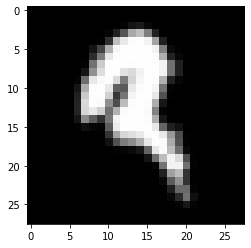

In [37]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Shape:', img.shape)
print('Label:', label-1)

Shape: torch.Size([1, 28, 28])
Label: 0


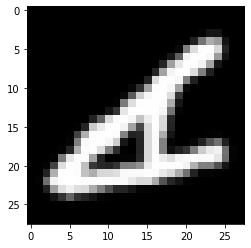

In [38]:
img, label = test_dataset[1]
plt.imshow(img[0], cmap='gray')
print('Shape:', img.shape)
print('Label:', label-1)

Shape: torch.Size([1, 28, 28])
Label: 3


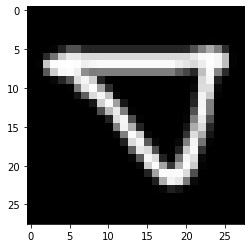

In [39]:
img, label = test_dataset[3000]
plt.imshow(img[0], cmap='gray')
print('Shape:', img.shape)
print('Label:', label-1)

In [40]:
img.unsqueeze(0).shape

torch.Size([1, 1, 28, 28])

#### Test the model on the test dataset

In [41]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 0 , Predicted: 4


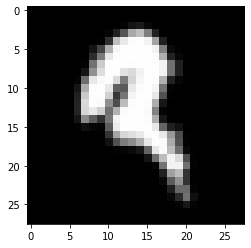

In [42]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label-1, ', Predicted:', predict_image(img, model))

Label: 0 , Predicted: 0


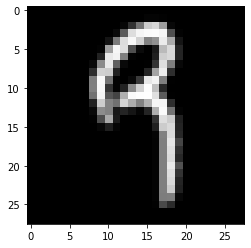

In [43]:
img, label = test_dataset[30]
plt.imshow(img[0], cmap='gray')
print('Label:', label-1, ', Predicted:', predict_image(img, model))

Label: 5 , Predicted: 5


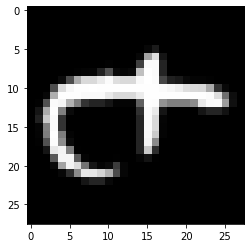

In [45]:
img, label = test_dataset[4000]
plt.imshow(img[0], cmap='gray')
print('Label:', label-1, ', Predicted:', predict_image(img, model))

#### Evaluate the model on the test dataset

In [48]:
test_loader = DataLoader(test_dataset, batch_size=128)
result = evaluate(model, test_loader)
result

{'val_acc': 0.6949769854545593, 'val_loss': 1.1024410724639893}

#### The final accuracy of the model on the test dataset is 69.50% using logistic regression.